#Project 8 - Anomaly and Novelty Detection - Wilfredo Aaron Sosa Ramos

#Data Engineering Lifecycle

#Phase 1: Ingestion

In [63]:
#Mount the google drive connection to our dataset
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [64]:
import pandas as pd
df = pd.read_csv('/content/drive/My Drive/AI/Project 8/dataset/air_pollution new.csv')

In [65]:
df.head()

,city,country,2017,2018,2019,2020,2021,2022,2023
0,Kabul,Afghanistan,0,61.8,58.8,46.5,37.5,17.1,18.1
1,Tirana,Albania,0,0,0,16.0,12.5,14.5,14.4
2,Algiers,Algeria,0,0,21.2,20.2,20.0,17.8,17.4
3,Ordino,Andorra,0,0,0,7.4,7.3,5.4,5.3
4,Luanda,Angola,0,0,15.9,13.0,11.0,8.8,8.7


In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6985 entries, 0 to 6984
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   city     6985 non-null   object
 1   country  6985 non-null   object
 2   2017     6985 non-null   object
 3   2018     6985 non-null   object
 4   2019     6985 non-null   object
 5   2020     6985 non-null   object
 6   2021     6985 non-null   object
 7   2022     6985 non-null   object
 8   2023     6985 non-null   object
dtypes: object(9)
memory usage: 491.3+ KB


In [67]:
df.describe()

,city,country,2017,2018,2019,2020,2021,2022,2023
count,6985,6985,6985,6985,6985,6985,6985,6985,6985
unique,6852,133,504,497,548,534,616,666,649
top,Hamilton,USA,0,0,0,0,0,8.4,8.8
freq,6,2612,4852,4681,3337,3125,786,87,91


In [68]:
df.shape

(6985, 9)

In [69]:
df.drop(["city", "country"], axis=1, inplace=True)

# Phase 2: Transformation

In [70]:
features = df.columns

In [71]:
features

Index(['2017', '2018', '2019', '2020', '2021', '2022', '2023'], dtype='object')

In [72]:
for feature_name in features:
    df[feature_name] = df[feature_name].str.replace('.', '').astype(float)

<ipython-input-72-2b9cbb0a47fb>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[feature_name] = df[feature_name].str.replace('.', '').astype(float)


In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6985 entries, 0 to 6984
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   2017    6985 non-null   float64
 1   2018    6985 non-null   float64
 2   2019    6985 non-null   float64
 3   2020    6985 non-null   float64
 4   2021    6985 non-null   float64
 5   2022    6985 non-null   float64
 6   2023    6985 non-null   float64
dtypes: float64(7)
memory usage: 382.1 KB


In [74]:
df.tail(5)

,2017,2018,2019,2020,2021,2022,2023
6980,0.0,0.0,0.0,0.0,368.0,146.0,150.0
6981,0.0,0.0,0.0,0.0,201.0,245.0,245.0
6982,0.0,0.0,0.0,0.0,62.0,55.0,55.0
6983,0.0,0.0,0.0,0.0,0.0,129.0,124.0
6984,0.0,0.0,0.0,0.0,246.0,246.0,244.0


In [75]:
df.isnull().sum()

2017    0
2018    0
2019    0
2020    0
2021    0
2022    0
2023    0
dtype: int64

In [76]:
df.isna().sum()

2017    0
2018    0
2019    0
2020    0
2021    0
2022    0
2023    0
dtype: int64

In [77]:
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [78]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

In [79]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

In [80]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ])

# Phase 3: Serving

#Isolation Forest

In [81]:
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import numpy as np

In [82]:
df_encoded = preprocessor.fit_transform(df)
df_encoded = pd.DataFrame(df_encoded, columns=df.columns)

In [83]:
isolation_forest_model = IsolationForest(contamination=0.1)

In [84]:
isolation_forest_model.fit(df_encoded)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.1)

In [85]:
df_encoded['anomaly_score'] = isolation_forest_model.decision_function(df_encoded)
df_encoded['anomaly'] = isolation_forest_model.predict(df_encoded[numeric_features])

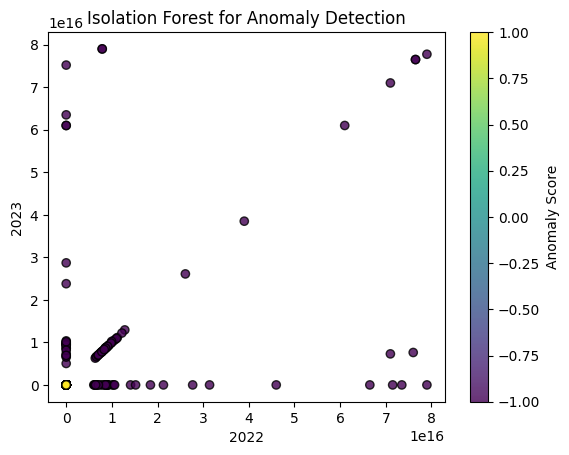

In [86]:
plt.scatter(df_encoded['2022'], df_encoded['2023'], c=df_encoded['anomaly'], cmap='viridis', marker='o', edgecolors='k', alpha=0.8)
plt.colorbar(label='Anomaly Score')
plt.xlabel('2022')
plt.ylabel('2023')
plt.title('Isolation Forest for Anomaly Detection')

plt.show()

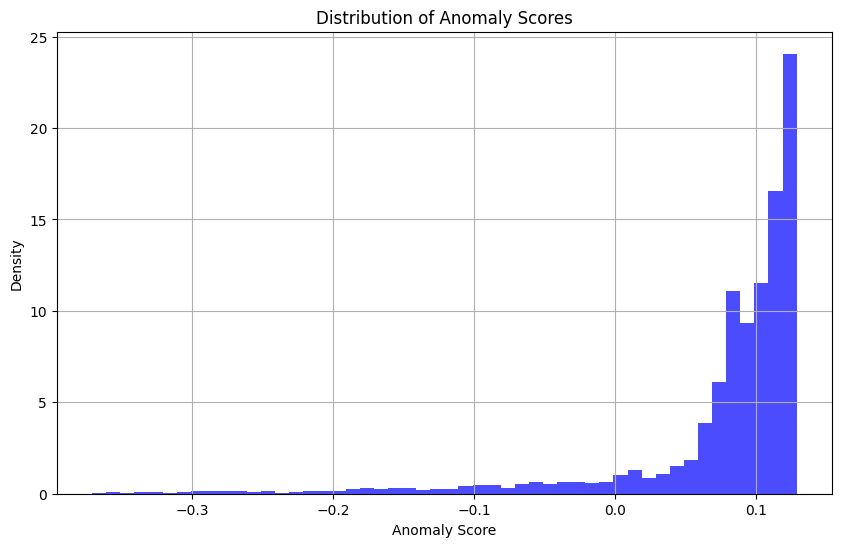

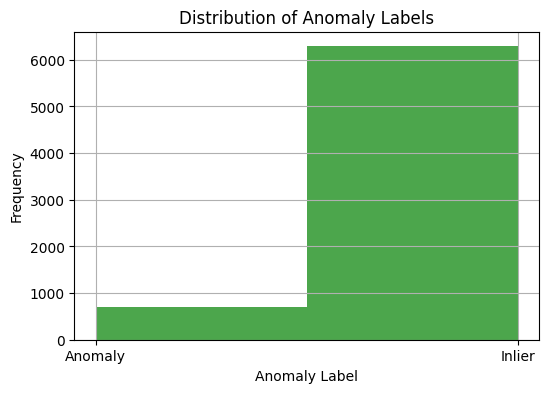

In [87]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(df_encoded['anomaly_score'], bins=50, density=True, alpha=0.7, color='blue')
plt.xlabel('Anomaly Score')
plt.ylabel('Density')
plt.title('Distribution of Anomaly Scores')
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 4))
plt.hist(df_encoded['anomaly'], bins=[-1, 0, 1], alpha=0.7, color='green')
plt.xlabel('Anomaly Label')
plt.ylabel('Frequency')
plt.title('Distribution of Anomaly Labels')
plt.xticks([-1, 1], ['Anomaly', 'Inlier'])
plt.grid(True)
plt.show()


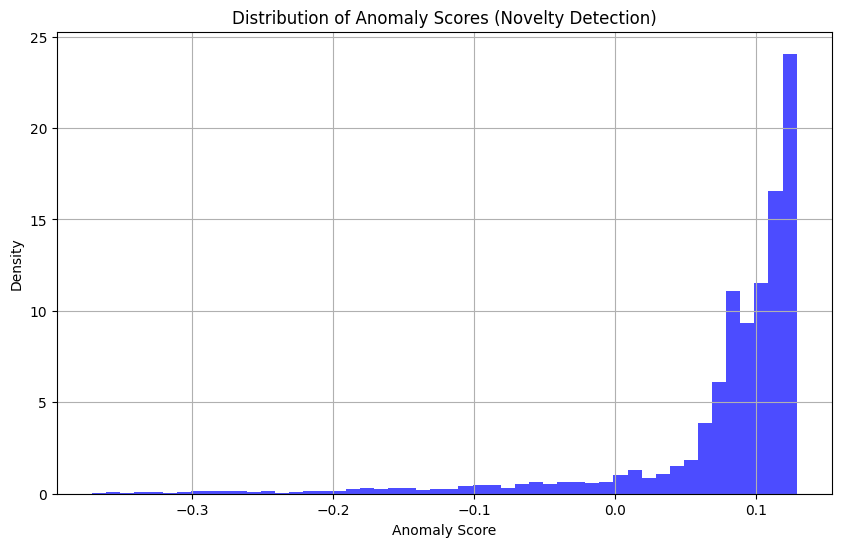

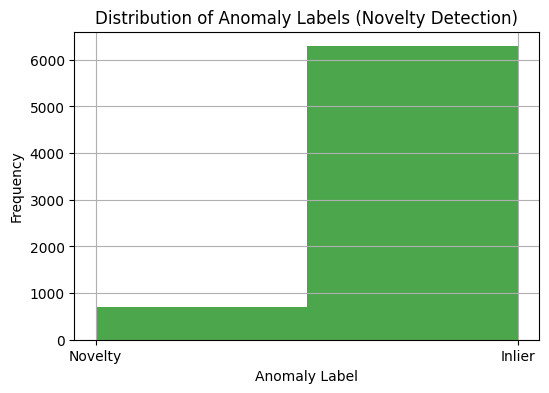

In [88]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(df_encoded['anomaly_score'], bins=50, density=True, alpha=0.7, color='blue')
plt.xlabel('Anomaly Score')
plt.ylabel('Density')
plt.title('Distribution of Anomaly Scores (Novelty Detection)')
plt.grid(True)
plt.show()

# Plotting anomaly labels
plt.figure(figsize=(6, 4))
plt.hist(df_encoded['anomaly'], bins=[-1, 0, 1], alpha=0.7, color='green')
plt.xlabel('Anomaly Label')
plt.ylabel('Frequency')
plt.title('Distribution of Anomaly Labels (Novelty Detection)')
plt.xticks([-1, 1], ['Novelty', 'Inlier'])
plt.grid(True)
plt.show()

# Local Outlier Factor

In [89]:
from sklearn.neighbors import LocalOutlierFactor

In [90]:
lof_model = LocalOutlierFactor(contamination=0.1)

In [92]:
df_encoded2 = preprocessor.fit_transform(df)
df_encoded2 = pd.DataFrame(df_encoded2, columns=df.columns)

lof_model.fit(df_encoded2)

LocalOutlierFactor(contamination=0.1)

In [93]:
df_encoded2['anomaly_score'] = -lof_model.negative_outlier_factor_
df_encoded2['anomaly'] = lof_model.fit_predict(df_encoded2[numeric_features])

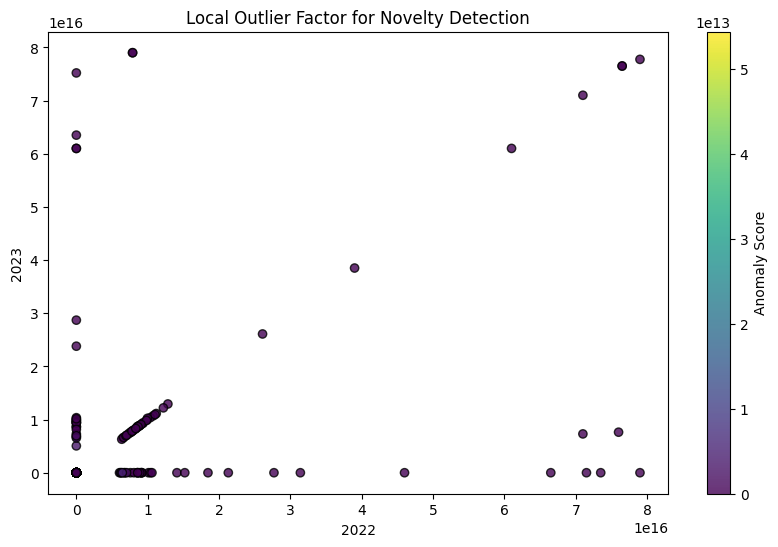

In [94]:
plt.figure(figsize=(10, 6))

plt.scatter(df_encoded2['2022'], df_encoded2['2023'], c=df_encoded2['anomaly_score'], cmap='viridis', marker='o', edgecolors='k', alpha=0.8)
plt.colorbar(label='Anomaly Score')
plt.xlabel('2022')
plt.ylabel('2023')
plt.title('Local Outlier Factor for Novelty Detection')

plt.show()

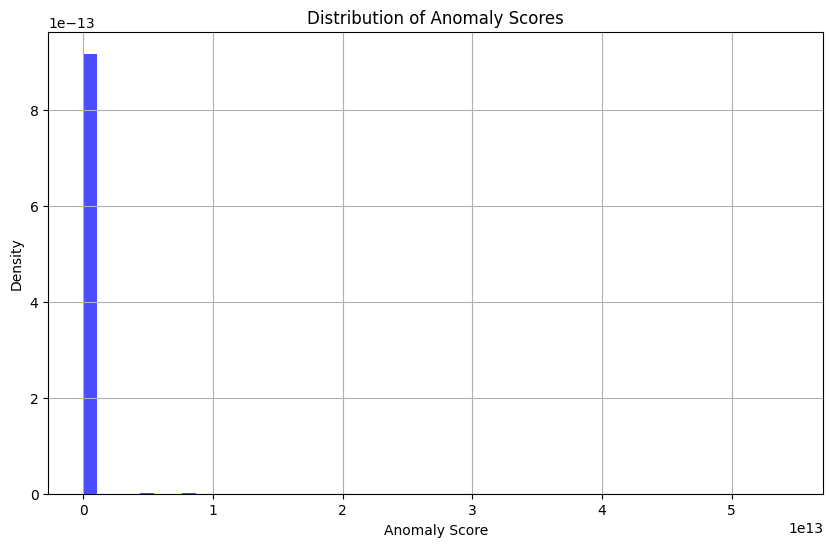

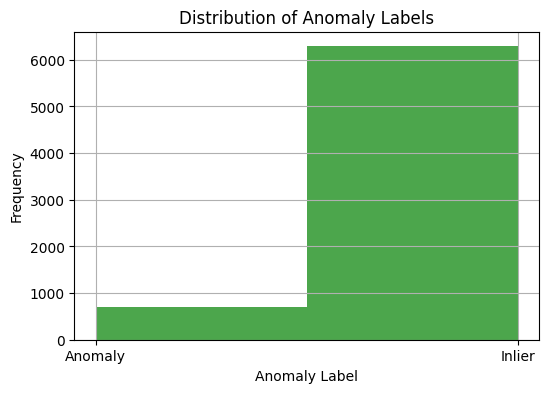

In [95]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(df_encoded2['anomaly_score'], bins=50, density=True, alpha=0.7, color='blue')
plt.xlabel('Anomaly Score')
plt.ylabel('Density')
plt.title('Distribution of Anomaly Scores')
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 4))
plt.hist(df_encoded2['anomaly'], bins=[-1, 0, 1], alpha=0.7, color='green')
plt.xlabel('Anomaly Label')
plt.ylabel('Frequency')
plt.title('Distribution of Anomaly Labels')
plt.xticks([-1, 1], ['Anomaly', 'Inlier'])
plt.grid(True)
plt.show()


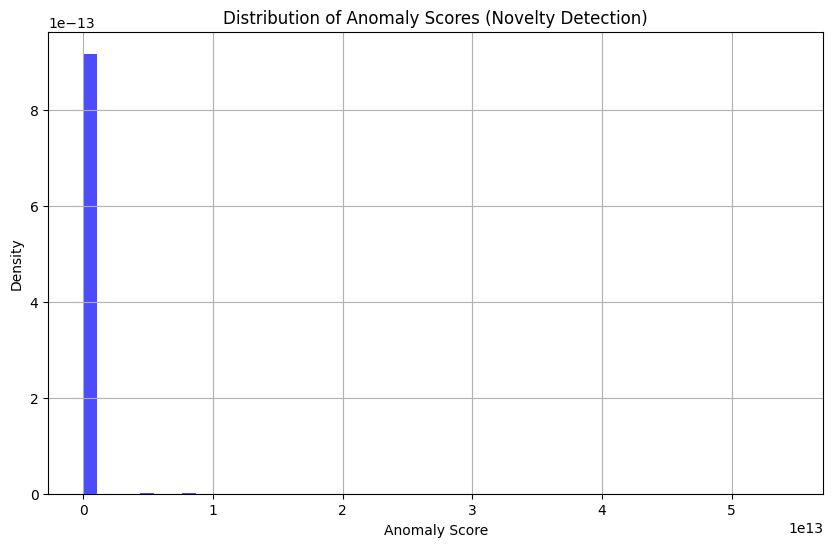

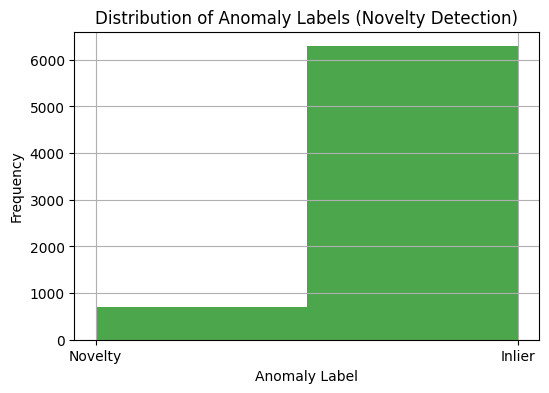

In [96]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(df_encoded2['anomaly_score'], bins=50, density=True, alpha=0.7, color='blue')
plt.xlabel('Anomaly Score')
plt.ylabel('Density')
plt.title('Distribution of Anomaly Scores (Novelty Detection)')
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 4))
plt.hist(df_encoded2['anomaly'], bins=[-1, 0, 1], alpha=0.7, color='green')
plt.xlabel('Anomaly Label')
plt.ylabel('Frequency')
plt.title('Distribution of Anomaly Labels (Novelty Detection)')
plt.xticks([-1, 1], ['Novelty', 'Inlier'])
plt.grid(True)
plt.show()